In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

nitrogen_df = pd.read_csv('Nitrogen_loads.csv')
nitrogen_df = nitrogen_df.drop(['Land-River Segment', 'FIPS'], axis=1)
nitrogen_df.head()

,County,Tributary Basin,Major Basin,Source Sector,"Total N, 1985 (lb.)","Total N, 2007 (lb.)","Total N, 2009 (lb.)","Total N, 2010 (lb.)","Total N, 2011 (lb.)","Total N, 2012 (lb.)","Total N, 2013 (lb.)","Total N, 2014 (lb.)","Total N, 2015 (lb.)","Total N, 2016 (lb)","Total N Target, 2017 (lb.)",Total N Target 2025 (lb.)
0,ALLEGANY,Upper Potomac,Potomac River Basin,Forest,51155.919440,44291.188480,44013.497320,44071.130370,44127.954830,44065.744140,43439.700190,42644.769650,42279.000080,43150.365480,44567.218760,44936.366390
1,ALLEGANY,Upper Potomac,Potomac River Basin,Non-Tidal Atm,23.744801,11.600470,11.600470,11.600470,11.600470,11.600470,11.600470,11.600470,11.600470,11.600470,11.600469,11.600469
2,ALLEGANY,Upper Potomac,Potomac River Basin,Septic,593.984192,539.573425,534.814819,532.096191,530.284119,527.565125,687.846619,553.043579,547.539978,542.895386,466.803913,421.463309
3,ALLEGANY,Upper Potomac,Potomac River Basin,Stormwater,4163.487261,2510.113876,2473.745250,2463.564675,2455.817180,2456.445068,5187.855037,2569.293440,2718.073060,2686.010203,2278.617397,2148.532161
4,ALLEGANY,Upper Potomac,Potomac River Basin,Wastewater,153.179901,54.931515,298.770703,111.263986,113.858285,101.050881,93.216107,170.578984,0.902378,68.777241,160.712233,68.673253


precipitation trends in Mayrland

http://marylandclimateandweather.weathertogether.net/maryland-statewide-average-precipitation-1895-2017/

Guidelines for the project

https://mde.maryland.gov/programs/Water/TMDL/TMDLImplementation/Pages/overview.aspx

Will Maryland meet the projects set for itself by 2025?

Show how much each sector has decreased over time 

Here we are cleaning the data set in order to do analysis later. We removed Land-River Segment and FIP because they are not necessary for our analysis (should we explain why they are not necessary?). Then we use the pandas features melt to change the format of the data from horizontal to verticle.


In [3]:
import re

temp_dict = {}
for column in nitrogen_df.columns[4:]:
    temp_dict[column] = re.findall("\d{4}", column)[0]

nitrogen_df = nitrogen_df.rename(columns=temp_dict)
nitrogen_df = pd.melt(nitrogen_df,id_vars=['County','Tributary Basin','Major Basin','Source Sector'], \
                      var_name='Year', value_name='Total lbs.')

In [4]:
desired_bodies = ['Lower Western Shore','Upper Western Shore','Lower Eastern Shore','Upper Eastern Shore']
all_bodies = nitrogen_df['Tributary Basin'].unique()
# Sets: all bodies - desired bodies = unwanted bodies
unwanted_bodies = list(set(all_bodies)-set(desired_bodies))

In [5]:
nitrogen_df = nitrogen_df.set_index("Major Basin")
nitrogen_df.drop(['Potomac River Basin', 'Patuxent River Basin','Susquehanna River Basin'],axis=0,inplace=True)
nitrogen_df = nitrogen_df.reset_index()

nitrogen_df = nitrogen_df.set_index("Tributary Basin")
nitrogen_df.drop(['Patuxent', 'Choptank', 'Patapsco/Back'],axis=0,inplace=True)
nitrogen_df = nitrogen_df.reset_index()

Ignore results for 2017 and 2025 because those were predictions that the reseachers made. The only measured values are 2007-2016

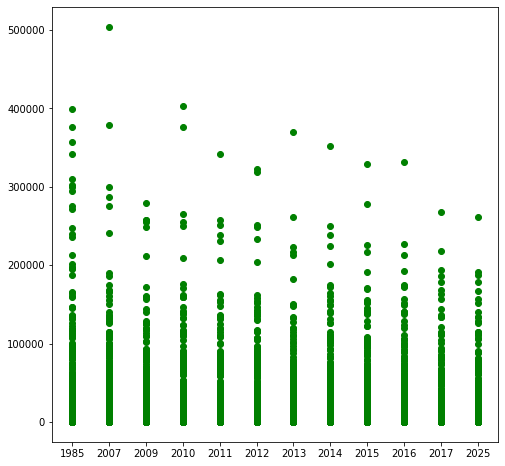

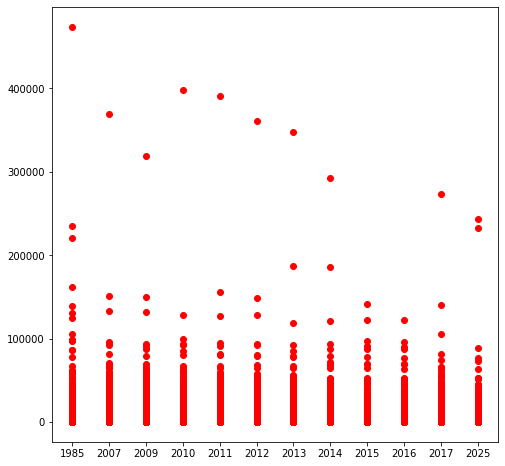

In [10]:
fig = plt.figure(figsize = (8, 8))
eastern_shore = nitrogen_df[nitrogen_df['Major Basin'] == 'Eastern Shore of Chesapeake Bay']
western_shore = nitrogen_df[nitrogen_df['Major Basin'] == 'Western Shore of Chesapeake Bay']
plt.scatter(eastern_shore['Year'], eastern_shore['Total lbs.'], c = "green")
fig = plt.figure(figsize = (8, 8))
plt.scatter(western_shore['Year'], western_shore['Total lbs.'], c = "red")

Text(0.5, 1.0, 'Western Shore Total Pounds of Nitrogen per Year')

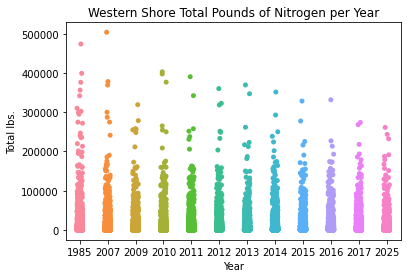

In [11]:
sns.stripplot(data = eastern_shore, x = eastern_shore['Year'], y = eastern_shore['Total lbs.'])
plt.title("Eastern Shore Total Pounds of Nitrogen per Year")

sns.stripplot(data = western_shore, x = western_shore['Year'], y = western_shore['Total lbs.'])
plt.title("Western Shore Total Pounds of Nitrogen per Year")

Text(0.5, 1.0, 'Average yearly Nitrogen pollution 2007-2016')

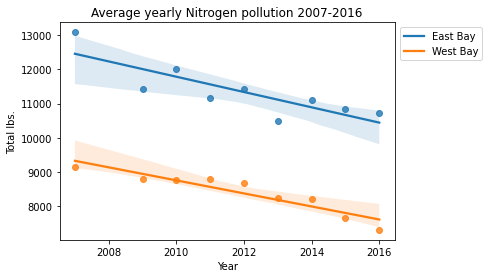

In [36]:
import seaborn as sns

ave_N =  nitrogen_df.groupby(['Major Basin','Year']).mean().reset_index()
basins = ave_N['Major Basin'].unique()

for basin in basins:
    data = ave_N[ave_N['Major Basin'] == basin]
    X = data.Year[1:-2].astype(int)
    y = data["Total lbs."][1:-2]
    sns.regplot(x=X, y=y)

plt.legend(labels=["East Bay","West Bay"], loc = 2, bbox_to_anchor = (1,1))
plt.title("Average yearly Nitrogen pollution 2007-2016")

In [24]:
phosphorus_df = pd.read_csv('Phosphorus_loads.csv')
phosphorus_df = phosphorus_df.drop(['Land-River Segment', 'FIPS'], axis=1)

In [25]:
temp_dict = {}
#changes Total P, #### (lb.) -> ####
for column in phosphorus_df.columns[4:]:
    temp_dict[column] = re.findall("\d{4}", column)[0]

phosphorus_df = phosphorus_df.rename(columns=temp_dict)
phosphorus_df = pd.melt(phosphorus_df,id_vars=['County','Tributary Basin','Major Basin','Source Sector'], var_name='Year', value_name='Total lbs.')

Text(0.5, 1.0, 'Western Shore Phosphorus Pollution over time.')

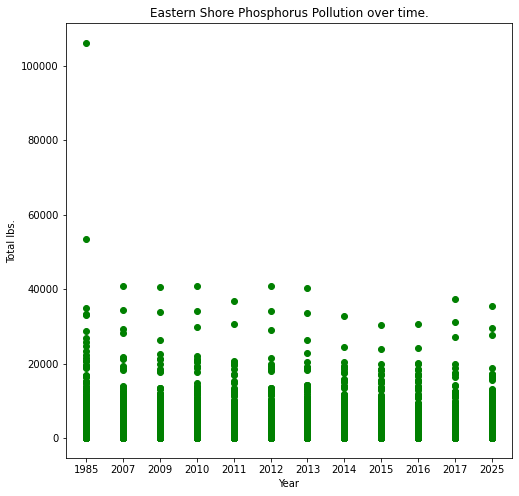

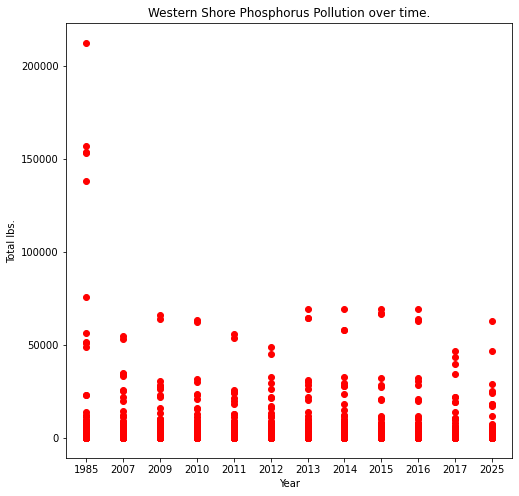

In [30]:
eastern_phosphorus = phosphorus_df[phosphorus_df['Major Basin'] == "Eastern Shore of Chesapeake Bay"]
western_phosphorus = phosphorus_df[phosphorus_df['Major Basin'] == "Western Shore of Chesapeake Bay"]

fig = plt.figure(figsize = (8, 8))
plt.scatter(eastern_phosphorus['Year'], eastern_phosphorus['Total lbs.'], c = "green")
plt.xlabel("Year")
plt.ylabel("Total lbs.")
plt.title("Eastern Shore Phosphorus Pollution over time.")

fig = plt.figure(figsize = (8, 8))
plt.scatter(western_phosphorus['Year'], western_phosphorus['Total lbs.'], c = "red")
plt.xlabel("Year")
plt.ylabel("Total lbs.")
plt.title("Western Shore Phosphorus Pollution over time.")

Text(0.5, 1.0, 'Average yearly Phosphorus pollution 2007-2016')

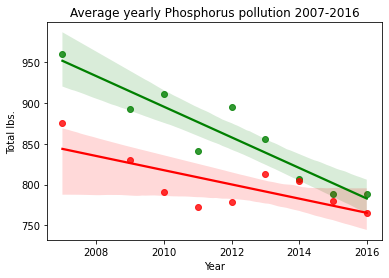

In [31]:
import seaborn as sns

eastern_phosphorus_ave = eastern_phosphorus.groupby('Year').mean().reset_index()
western_phosphorus_ave = western_phosphorus.groupby('Year').mean().reset_index()

X = eastern_phosphorus_ave.Year[1:-2].astype(int)
y = eastern_phosphorus_ave["Total lbs."][1:-2]
ax = sns.regplot(x=X, y=y, color = "green")

X = western_phosphorus_ave.Year[1:-2].astype(int)
y = western_phosphorus_ave["Total lbs."][1:-2]
sns.regplot(ax= ax, x=X, y=y, color = "red")

# ave_P =  phosphorus_df.groupby(['Major Basin','Year']).mean().reset_index()
# basins = ave_P['Major Basin'].unique()
# # color = {basins[0]: "red", basins[1]: "green"}
# for basin in basins:
#     data = ave_P[ave_P['Major Basin'] == basin]
#     X = data.Year[1:-2].astype(int)
#     y = data["Total lbs."][1:-2]
#     sns.regplot(x=X, y=y)#, color = color[basin])

ax.set_title("Average yearly Phosphorus pollution 2007-2016")

#GREEN IS THE EASTERN BAY
#RED IS THE WESTERN BAY

The reason that the eastern shore has more pollution is due to nitrogen in groundwater. This is evidenced here https://www.chesapeakebay.net/news/blog/excess_nitrogen_phosphorus_flow_from_eastern_shore_to_bay_waters

In [17]:
algae_df = pd.read_csv('LivingResourcesReportedStation.csv', low_memory =False, parse_dates=True)

In [18]:
desired = ['Prorocentrum minimum','Prorocentrum micans','Blue green sphere','Prorocentrum gracile']
all_alg = algae_df['LatinName'].unique()
# Sets: all bodies - desired bodies = unwanted bodies
unwanted = list(set(all_alg)-set(desired))

algae_df = algae_df.set_index("LatinName")
algae_df.drop(unwanted,axis=0,inplace=True)
algae_df = algae_df.reset_index()

algae_df = algae_df.rename(columns={"ReportingValue": "ReportingValue(L)"})
algae_df = algae_df.drop(['ReportingUnit','Parameter','SampleType','SampleNumber','TSN','NODCCode','SPECCode'], axis=1)

year = []
for date in algae_df.SampleDate:
    year.append(date[-4:])    
algae_df['Year'] = year
algae_df['Year'] = algae_df['Year'].astype(int)

https://www.cbf.org/how-we-save-the-bay/chesapeake-clean-water-blueprint/the-history-of-bay-cleanup-efforts.html
This link may explain why there is a general decrease in prorocentrum minimum over the years

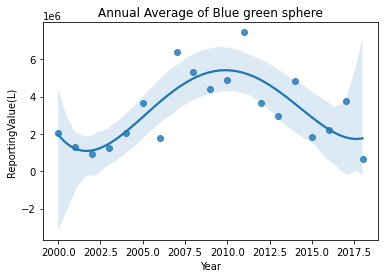

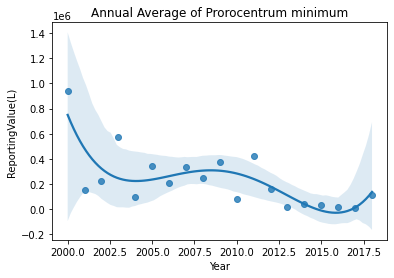

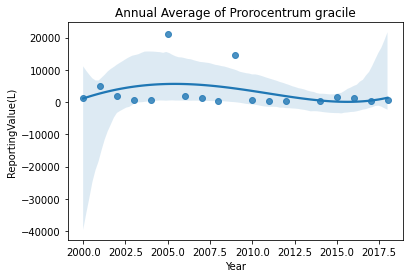

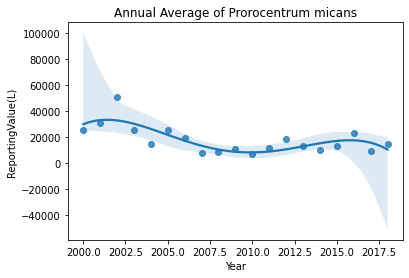

In [19]:
for name in algae_df.LatinName.unique():
    fig, ax = plt.subplots()
    temp = algae_df[algae_df['LatinName'] == name]
    temp = temp.groupby('Year').mean().reset_index()
    ax = sns.regplot(data = temp, order=4, x='Year', y='ReportingValue(L)')
    title = "Annual Average of "+name
    ax.set_title(title)

In [20]:
prorocentrum_micans = algae_df[algae_df['LatinName'] == 'Prorocentrum micans']
prorocentrum_gracile = algae_df[algae_df['LatinName'] == 'Prorocentrum gracile']

In [21]:
# oxygen_levels = pd.read_csv('AN_OCEAN_2016-2018.csv')
# oxygen_levels.plot.scatter(x='Year',y='Oxygen (millilitres O2 per liter)', c='DarkBlue')

In [37]:
activites_df = pd.read_csv('Reduction_Activities.csv')
activites_df["Fiscal Year"] = list(range(2000,2015))

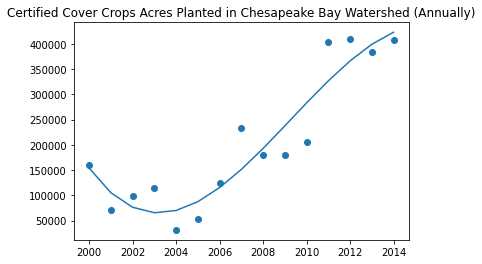

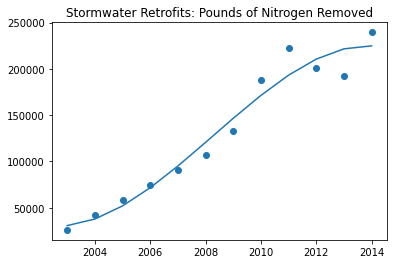

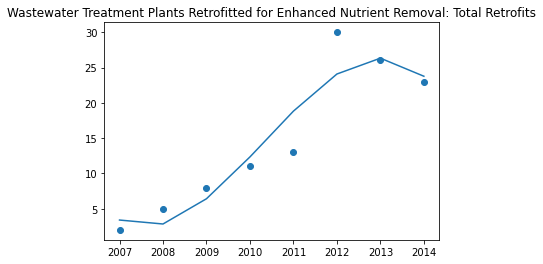

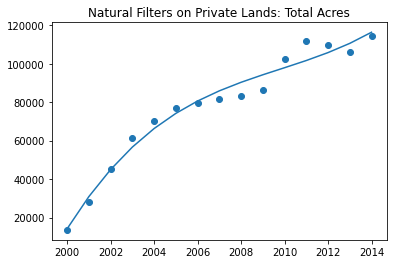

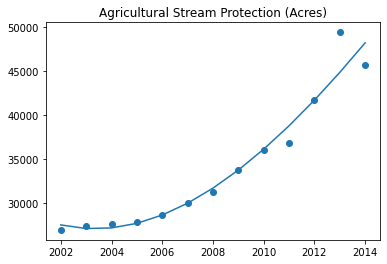

In [26]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

col_names = activites_df.columns
#each of the columns selected give the total amount of that activity for each year
temp = [1,2,5,8,11]

for i in temp:
    fig, ax = plt.subplots()
    
    activity = col_names[i]

    #to remove NaN values in the dataframe
    y = [i for i in activites_df[activity] if pd.notna(i)]
    x = activites_df['Fiscal Year'][-len(y):].array.reshape(-1, 1)

    polynomial_features= PolynomialFeatures(degree=3)
    x_poly = polynomial_features.fit_transform(x)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)

    model = LinearRegression()
    model.fit(x_poly, y)
    y_poly_pred = model.predict(x_poly)
    plt.scatter(x, y)
    plt.plot(x, y_poly_pred)
    ax.set_title(activity)
    plt.show()